In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import pickle
import json
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from icecream import ic
from import_casa import casa

In [3]:
import torch

In [4]:
data_dir = casa.get_data_path() / "eda/context"

In [53]:
context_v_path = casa.get_data_path() / "eda/context/context_v.xlsx"
context_v = pd.read_excel(context_v_path, sheet_name=0, index_col=None).iloc[1:, 1:8]
context_v.iloc[0, :]

annotator                                                                  amy
context                                               台星的態度就是在等宿主台哥，逸以待勞，準備寄生。
rating                                                                     1.0
V.+                                                   等/VC 逸以待勞/VH 準備/VF 寄生/VA
sentiment_annotation                      等/VC.neu 逸以待勞/VH.n 準備/VF.neu 寄生/VA.n
sentiment_annotation_events    (main) 等/VC.neu (main) 逸以待勞/VH.n (main) 寄生/VA.n
cues                                                                       NaN
Name: 1, dtype: object

In [57]:
cc_v_path = casa.get_data_path() / "eda/context/context_closed_class.xlsx"
closed_ctx = pd.read_excel(cc_v_path, sheet_name=0, index_col=None).iloc[:, 1:-1]
closed_ctx["index"] = np.arange(1, closed_ctx.shape[0]+1)
closed_ctx.set_index("index", inplace=True)
closed_ctx.iloc[0, :]

annotator                            amy
context         台星的態度就是在等宿主台哥，逸以待勞，準備寄生。
rating                               1.0
closed_class         的　 就　 是　 在　 ，　 ，　 。
cnstr                                NaN
Name: 1, dtype: object

In [202]:
def align_annot(text, frames):
    if not frames:
        return [text, []]       
    frame_cur = 0
    align_frame = []
    for text_cur in range(len(text)):        
        annot_key = frames[frame_cur][0]                
        if text[text_cur:text_cur+len(annot_key)] == annot_key:
            align_frame.append((text_cur, text_cur+len(annot_key), *frames[frame_cur]))
            frame_cur += 1
            text_cur = text_cur+len(annot_key)
        else:
            text_cur += 1
        if text_cur >= len(text) or frame_cur >= len(frames):
            break
    return align_frame

def make_relation(rel_key, rel_map):        
    rel_frame = []
    main_ents = rel_map.get("main", [])
    for cause_x in rel_map.get(rel_key, []):
        rel_label = cause_x[3]
        rel_id = re.findall(r"\d", rel_label)
        if rel_id:
            main = [x for x in main_ents if x[3] == f"main{rel_id[0]}"]
        else:
            main = [x for x in main_ents if x[3] == f"main"]
        if main:
            rel_frame.append((main[0], cause_x))            
    return rel_frame

def make_relation_frames(aligned_frames):
    rel_map = {}
    for frame_x in aligned_frames:
        rel_key = re.sub("\d", "", frame_x[3])
        rel_map.setdefault(rel_key, []).append(frame_x)
            
    cause_rels = make_relation("cause", rel_map)
    conseq_rels = make_relation("conseq", rel_map)    
    return [*cause_rels, *conseq_rels]
    
def make_annotation_frame(context_v, closed_ctx, target_col=5):
    annot_data = []
    for row, row_c in zip(context_v.itertuples(), closed_ctx.itertuples()):
        assert row[2].replace(" ", "") == row_c[2].replace(" ", "")
        idx = row[0]        
        text, annot_raw = row[2], row[target_col+1] 
        if not isinstance(annot_raw, str):
            continue
                
        if isinstance(row_c[4], str):            
            cc_frame = align_annot(text, [(x.strip(),) for x in row_c[4].split("\u3000")])
        else:
            cc_frame = []
        cx = row_c[5].strip() if isinstance(row_c[5], str) else ""
        
        rating = row[3]
        annot_items = re.findall(r"(?:\((\w+)\))?\s*(\w+)/(\w+)\.(\w+)", annot_raw)                    
        annot_frames = []
        for x in annot_items:
            if x[0]:
                frame_x = (x[1], x[0], *x[2:])
            else:
                frame_x = (x[1], "none", *x[2:])
            annot_frames.append(frame_x)
        text = text.replace(" ", "")
        # print(text, annot_frames)
        if annot_frames:
            annot_frames = align_annot(text, annot_frames)
            rel_frames = make_relation_frames(annot_frames)
            annot_data.append({
                "index": idx,
                "text": text, 
                "rating": rating,
                "events": annot_frames, 
                "closed": cc_frame,
                "cx": cx,
                "relations": rel_frames})
    return annot_data


In [203]:
target_col_idx = context_v.columns.values.tolist().index("sentiment_annotation_events")
annot_data = make_annotation_frame(context_v, closed_ctx, target_col=target_col_idx)

In [204]:
len(annot_data)

96

## Encode to vectors

In [153]:
def collect_vectors(hidden, start, end):
    if start >= end or end > hidden.shape[0]:        
        return torch.tensor([]).numpy()
    assert hidden.ndim == 2
    vecs = hidden[start:end, :].mean(axis=0).numpy()
    return vecs

In [267]:
from transformers import AutoModelForTokenClassification, BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model = AutoModelForTokenClassification.from_pretrained(data_dir)

def make_context_eda_vec(annot_data, layer=12):
    rng = random.Random(12345)
    instances = []

    for annot_item in tqdm(annot_data):
        text = annot_item["text"]
        rating = annot_item["rating"]    
        rating = 3 if np.isnan(rating) else rating
        xs = tokenizer(list(text), return_tensors="pt", is_split_into_words=True)        
        target_layer = layer # +1 for embedding offset and -1 for 0-index offset

        with torch.no_grad():
            out = model(**xs, output_hidden_states=True)
            hidden = out.hidden_states[target_layer][0, 1:-1, :]        

        # make construction vectors
        cx = annot_item["cx"]
        if cx:
            cx = re.sub(r"x+|\.+", "@", cx)
            xs = tokenizer(list(cx), return_tensors="pt", is_split_into_words=True)
            xs_ids = xs["input_ids"]
            xs_ids[xs_ids==137] = 103          
            with torch.no_grad():            
                out = model(**xs, output_hidden_states=True)
                vec = out.hidden_states[target_layer][0, 0, :]
            inst = {"hidden": vec, "label": "cx", "rating": rating}
            instances.append(inst)

        # make event instnaces
        for frame_x in annot_item["events"]:
            s, e = frame_x[:2]
            wclass = re.sub("\d", "", frame_x[3])
            pol = frame_x[5]
            vecs = collect_vectors(hidden, s, e)
            if vecs.size==0: continue           
            inst = {"hidden": vecs, "label": wclass, "polarity": pol, "rating": rating}
            instances.append(inst)

        # make closed class instances
        for frame_x in annot_item["closed"]:
            s, e = frame_x[:2]
            wclass = "closed"        
            vecs = collect_vectors(hidden, s, e)
            if vecs.size==0: continue
            inst = {"hidden": vecs, "label": wclass, "rating": rating}
            instances.append(inst)

        # make relation instances
        for frame_x, frame_y in annot_item["relations"]:
            sx, ex = frame_x[:2]
            sy, ey = frame_y[:2]
            wclass = "relation_" + frame_y[3]
            vecs_x = collect_vectors(hidden, sx, ex)
            vecs_y = collect_vectors(hidden, sy, ey)
            vecs = (vecs_x + vecs_y)/2
            if vecs.size==0: continue
            inst = {"hidden": vecs, "label": wclass, "rating": rating}
            instances.append(inst)

    with open(casa.get_data_path() / f"eda/context/eda_vec_instances_L{layer}.pkl", "wb") as fout:
        pickle.dump(instances, fout)
    return instances

In [268]:
_ = make_context_eda_vec(annot_data, 12);
_ = make_context_eda_vec(annot_data, 9);
_ = make_context_eda_vec(annot_data, 6);
_ = make_context_eda_vec(annot_data, 3);

In [269]:
for layer in (3,6,9,12):
    with open(casa.get_data_path() / f"eda/context/eda_vec_instances_L{layer}.pkl", "rb") as fin:
        inst[f"L{layer}"] = pickle.load(fin)

In [270]:
from collections import Counter
wclass = [x["label"] for x in inst["L3"]]
Counter(wclass)

(1188, 768)


Counter({'main': 115,
         'closed': 669,
         'cause': 74,
         'relation_cause': 50,
         'conseq': 64,
         'relation_conseq': 26,
         'cx': 26,
         'none': 164})

In [337]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

def plot_class(Hproj, instances, label_classes, ax, use_rating=False, layer=0):
    wclass = np.array([x["label"] for x in instances])
    mask = np.array([x in label_classes for x in wclass])
    rating = np.array([x["rating"] for x in instances])
    Xh = np.vstack([x["hidden"] for x in inst[f"L{layer}"]])    
    
    if use_rating:        
        labels = rating
        labels[rating<3] = 0
        labels[rating>=3] = 1
    else:
        labels = wclass
    
    label_enc = LabelEncoder()    
    Xh = Xh[mask, :]
    Xproj = Hproj[mask, :]
    labels = labels[mask]    
    label_ids = label_enc.fit_transform(labels)
    
    # classifier
    clf = SVC(kernel="linear", random_state=123)
    base_clf = DummyClassifier("most_frequent")
    scores = cross_val_score(clf, Xh, label_ids, cv=5)
    base_scores = cross_val_score(base_clf, Xh, label_ids, cv=5)
    M_clf, SE_clf = np.mean(scores), np.std(scores)/np.sqrt(len(base_scores))
    M_base, SE_base = np.mean(base_scores), np.std(base_scores)/np.sqrt(len(base_scores))   
    clf_a = SVC(kernel="linear", random_state=123)
    clf_a.fit(Xh, label_ids)
    score_a = clf_a.score(Xh, label_ids)

    scatter = ax.scatter(Xproj[:, 0], Xproj[:, 1], c=label_ids, cmap="Set1")
    ax.legend(handles=scatter.legend_elements()[0], labels=label_enc.classes_.tolist(), loc="lower left")
    ax.text(.95, .95, f"svm: {M_clf:.2f}$\pm${SE_clf: .2f}({score_a:.2f})", 
            backgroundcolor="#FFFFFFAA", fontsize=12,
            ha="right", va="top", transform=ax.transAxes)
    ax.text(.95, .85, f"fst: {M_base:.2f}$\pm${SE_base: .2f}", 
            backgroundcolor="#FFFFFFAA", fontsize=12,
            ha="right", va="top", transform=ax.transAxes)
    ax.set_title(f"L{layer}: {' '.join(label_classes)}")    

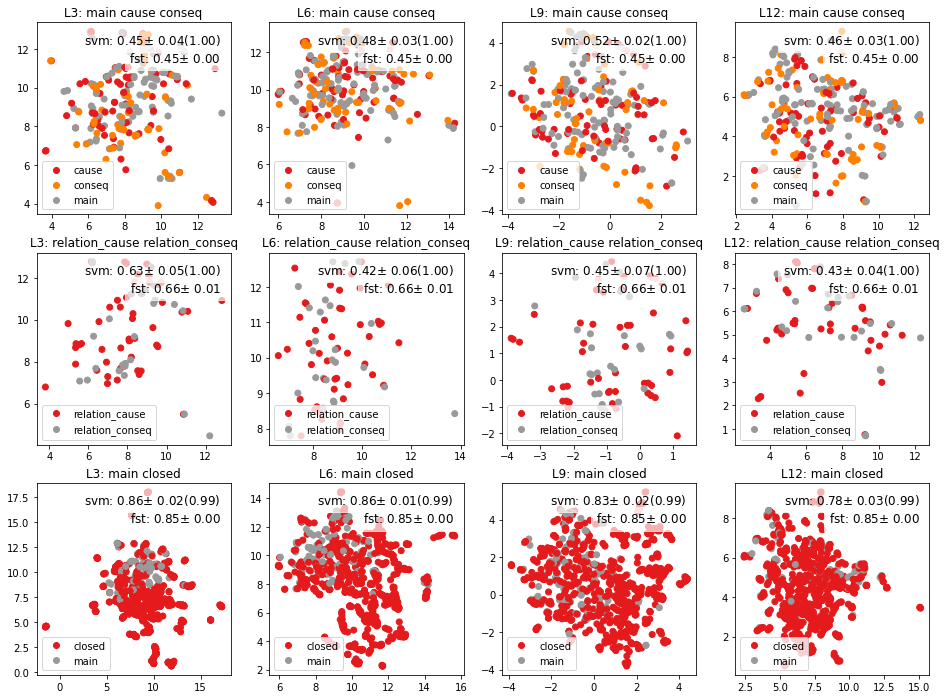

In [338]:
import umap
_, ax = plt.subplots(3, 4, figsize=(16,12))
for r, layer in tqdm(enumerate((3,6,9,12))):
    H = np.vstack([x["hidden"] for x in inst[f"L{layer}"]])
    proj = umap.UMAP(n_components=2, metric="cosine", n_neighbors=10)
    Hproj = proj.fit_transform(H)
    plot_class(Hproj, inst[f"L{layer}"], "main cause conseq".split(), ax[0][r], layer=layer)
    plot_class(Hproj, inst[f"L{layer}"], "relation_cause relation_conseq".split(), ax[1][r], layer=layer)
    plot_class(Hproj, inst[f"L{layer}"], "main closed".split(), ax[2][r], layer=layer)    
    # plot_class(Hproj, inst[f"L{layer}"], "ctx".split(), use_rating=False, ax[r][2])    

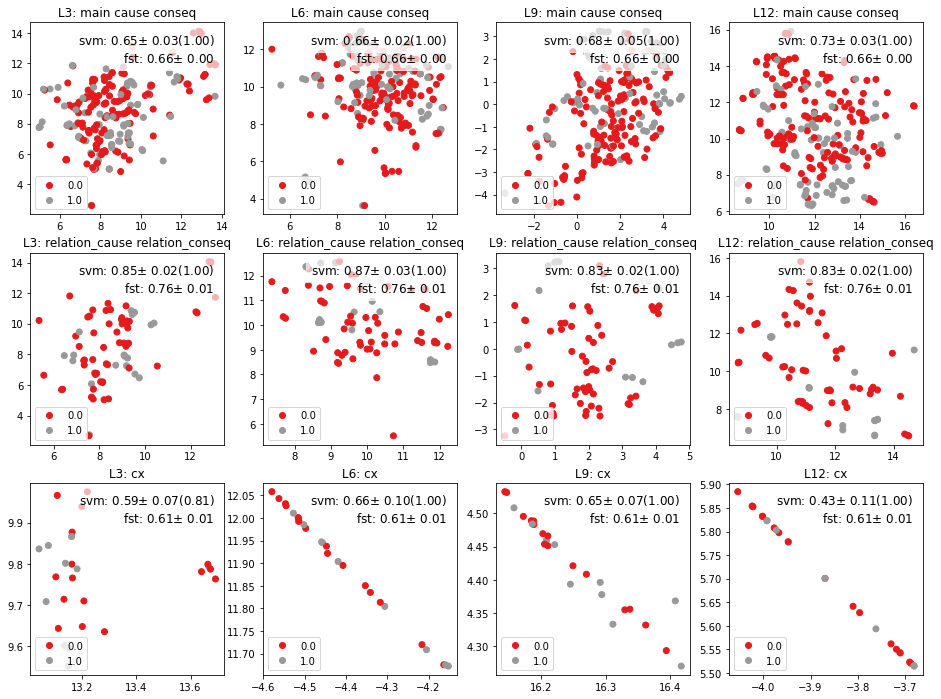

In [336]:
import umap
_, ax = plt.subplots(3, 4, figsize=(16,12))
for r, layer in tqdm(enumerate((3,6,9,12))):
    H = np.vstack([x["hidden"] for x in inst[f"L{layer}"]])
    proj = umap.UMAP(n_components=2, metric="cosine", n_neighbors=10)
    Hproj = proj.fit_transform(H)
    plot_class(Hproj, inst[f"L{layer}"], "main cause conseq".split(), ax[0][r], use_rating=True, layer=layer)
    plot_class(Hproj, inst[f"L{layer}"], "relation_cause relation_conseq".split(), ax[1][r], use_rating=True, layer=layer)
    plot_class(Hproj, inst[f"L{layer}"], "cx".split(), ax[2][r], use_rating=True, layer=layer)